# Getting started with DoWhy: A toy example
This is quick introduction to DoWhy causal inference library. We will load in a sample dataset and estimate causal effect from a (pre-specified)treatment variable to a (pre-specified) outcome variable.

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import dowhy.datasets

Let us first load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome.

Beta is the true causal effect.

In [3]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

    Z0        Z1        W0        W1        W2        W3        W4     v0  \
0  1.0  0.009729  1.500819 -0.830305 -0.631545  0.650276  0.680113   True   
1  1.0  0.858353  0.427973  0.725779  1.249435  0.315057  2.209682   True   
2  0.0  0.061243  3.282225 -1.896790  0.352931  0.591500  0.623877  False   
3  0.0  0.930844 -1.388907  0.166822  1.408813  3.918135  0.038157   True   
4  1.0  0.502423  0.390045 -0.832517  0.903912  0.766022 -1.891439   True   

           y  
0  15.765644  
1  21.029796  
2  17.211745  
3  28.222247  
4  18.359517  
digraph { U[label="Unobserved Confounders"]; U->y;v0->y;U->v0;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]

Note that we are using a pandas dataframe to load the data. At present, DoWhy only supports pandas dataframe as input.

## Interface 1 (recommended): Input causal graph
We now input a causal graph in the GML graph format (recommended). You can also use the DOT format.

In [4]:
# With graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"],
)

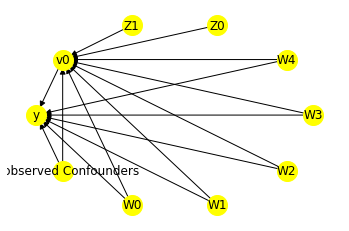

In [5]:
model.view_model()

The above causal graph shows the assumptions encoded in the cauasl model. We can now use this graph to first identify the causal effect (go from a causal estimand to a probability expression), and then estimate the causal effect.
 
**DoWhy philosophy: Keep identification and estimation separate**

Identification can be achieved without access to data, only the graph. This results in an expression to computed. This expression can then be computed using the available data in the estimation step. Important to understand that these are orthogonal steps.
### Identification

In [6]:
identified_estimand = model.identify_effect()
print(identified_estimand)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W3,W0,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W4,W2,U) = P(y|v0,W1,W3,W0,W4,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



### Estimation


In [7]:
causal_estimate = model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression"
)
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W3,W0,W4,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W3,W0,W4,W2,U) = P(y|v0,W1,W3,W0,W4,W2)

## Realized estimand
b: y~v0+W1+W3+W0+W4+W2
Target units: ate

## Estimate
Mean value: 10.00047841760085

Causal Estimate is 10.00047841760085


## Interface 2: Specify common causes and instruments

In [8]:
# Without graph
model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
)

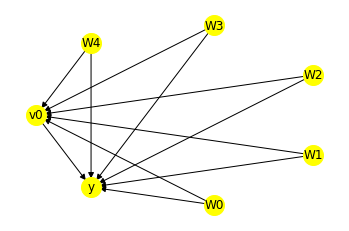

In [9]:
model.view_model()

We get the same causal graph. Now identification and estimation is done as before.
### Identification


In [10]:
identified_estimand = model.identify_effect()

### Estimation

In [11]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True,
)
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W1,W4,W3,W0,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W4,W3,W0,W2,U) = P(y|v0,W1,W4,W3,W0,W2)

## Realized estimand
b: y~v0+W1+W4+W3+W0+W2
Target units: ate

## Estimate
Mean value: 10.000478417600828
p-value: [0.]

Causal Estimate is 10.000478417600828


##Refuting the estimate
Now refuting the obtained estimate.

###Adding a random common cause variable

In [12]:
res_random = model.refute_estimate(
    identified_estimand, estimate, method_name="random_common_cause"
)
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:10.000478417600828
New effect:10.000479020970479



### Replacing treatment with a random (placebo) variable


In [13]:
res_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.000478417600828
New effect:0.021439282442244797
p value:0.34



### Removing a random subset of the data


In [14]:
res_subset = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.9,
)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.000478417600828
New effect:10.00045440991995
p value:0.43000000000000005

